In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib 
import scipy 
import sklearn

from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
import seaborn as sns
import statsmodels.api

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5] 



In [5]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [6]:
def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [7]:
df = pd.read_csv('/Users/paul.carroll/Documents/datasets/history_export_2020-02-15T14_22_15.csv')
df['date'] = pd.to_datetime(df[['Day','Month','Year']])
df.set_index('date',inplace=True, drop=True)
df.head(2)

,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (low resolution) daily sum [sfc],Total Cloud Cover daily mean [sfc],...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],Wind Speed daily max [900 mb],Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


In [8]:
rename_map = {
   
    'Total Precipitation (low resolution) daily sum [sfc]':    'Rainfall',
    'Total Cloud Cover daily mean [sfc]':'Cloudcover',
   'Sunshine Duration daily sum [sfc]': 'Sunshine',
    'Temperature daily mean [2 m above gnd]':'Temperature',
    'Temperature daily max [2 m above gnd]':'Temperature_max',
    'Relative Humidity daily mean [2 m above gnd]':'Humidity',
    'Mean Sea Level Pressure daily mean [MSL]':'Pressure_mean',
    'Shortwave Radiation daily sum [sfc]':'Radiation',
     'Wind Speed daily max [900 mb]':'max_wind_speed',
    'Wind Speed daily mean [900 mb]':'Windspeed_mean'
}

df.rename(columns=rename_map, inplace=True)
df.head(2)

,Year,Month,Day,Hour,Minute,Temperature,Humidity,Pressure_mean,Rainfall,Cloudcover,...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],max_wind_speed,Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


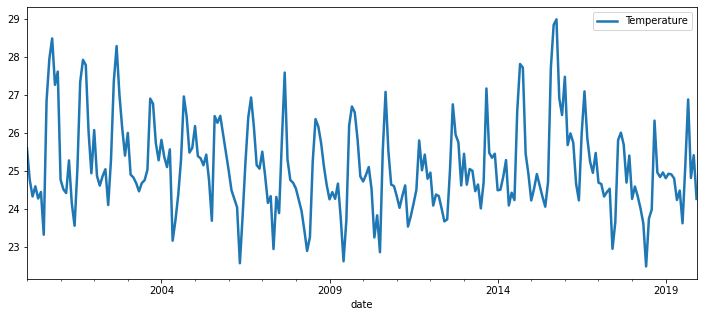

In [9]:
df.resample('M').mean()[['Temperature']].plot(lw=2.5,figsize=(12,5));

In [10]:
df= df.drop(['Hour','Minute'],axis=1)

In [11]:
check_stationarity(df.Temperature)

'Stationary	 p-value:1.7012041434276159e-12 	 lags:26


('Stationary', 1.7012041434276159e-12)

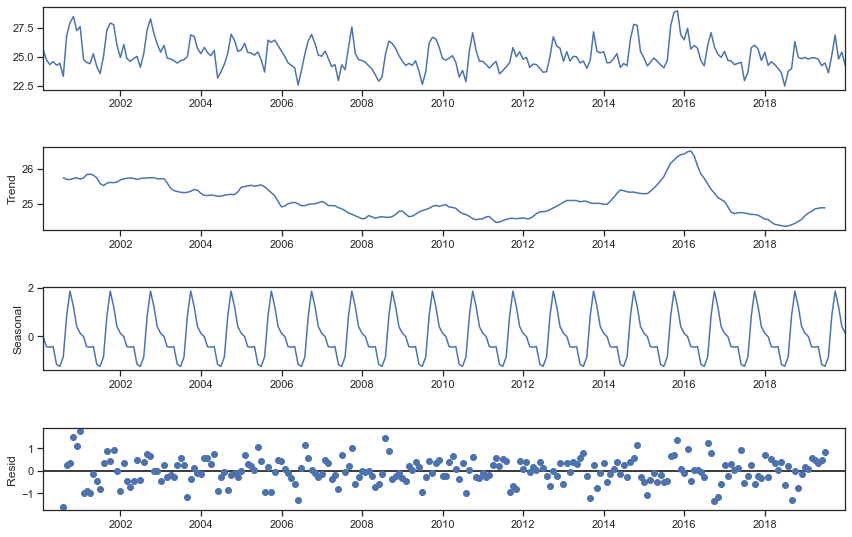

In [12]:
sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(df.resample('M').mean()[['Temperature']], period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();

In [13]:
#Differencing the milk dataset by 12, as from the seasonal_decompose the trend is annual. 
#milk_diff_12 = milk.diff(12).dropna()

In [14]:
#check_stationarity(milk_diff_12)
#however this is still not stationary.

In [15]:
#milk_diff_12_1= milk.diff(12).diff(1).dropna()
#check_stationarity(milk_diff_12_1)

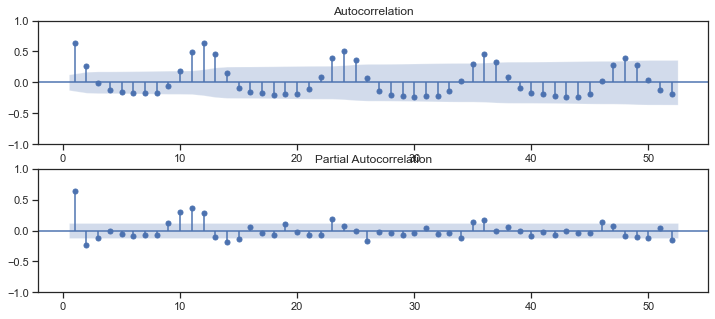

In [16]:
fig, ax= plt.subplots(2,1)
plot_acf(df.resample('M').mean()[['Temperature']], zero=False,
         ax=ax[0], lags=52)
plot_pacf(df.resample('M').mean()[['Temperature']],zero=False,
          ax=ax[1], lags=52)
plt.show();



In [17]:
dfm = df.resample('M').mean()

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#fitting a seasonal ARIMA model, SARIMAX, with p, d, q as 1,1,0 and 12 as S.
model = SARIMAX(dfm.Temperature, order =(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)



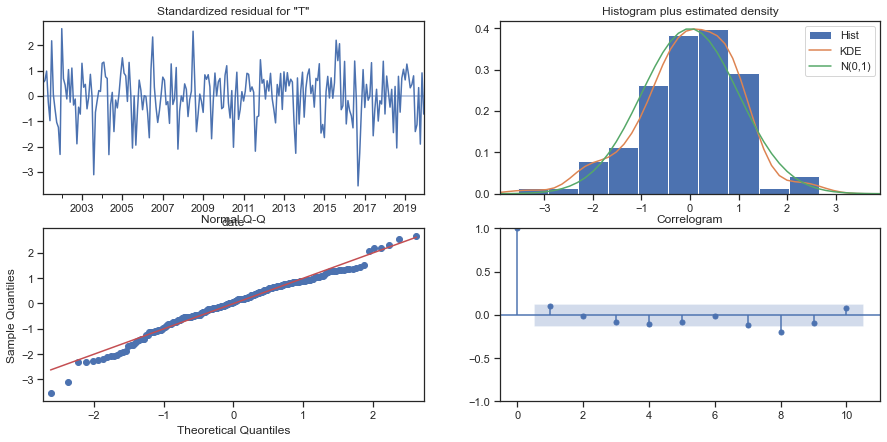

In [19]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -246.249
Date:                            Wed, 21 Sep 2022   AIC                            498.499
Time:                                    17:00:14   BIC                            508.774
Sample:                                01-31-2000   HQIC                           502.645
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6295      0.047    -13.477      0.000      -0.721      -0.538
ma.S.L12      -0.9912      0.664     -1.493      0.136      -2.293       0.310
sigma2         0.4404      0.288      1.528      0.127      -0.125       1.005
===================================================================================
Ljung-Box (L1) (Q):                   2.27   Jarque-Bera (JB):                11.82
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.45
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from pmdarima.arima import auto_arima
import pmdarima as pm

In [22]:
train, test = pm.model_selection.train_test_split(dfm.Temperature,test_size=0.15)
print(f'Train: {train.size}')
print(f'Test: {test.shape}')

Train: 204
Test: (36,)


In [23]:
auto_m = pm.auto_arima(train,
                       seasonal =True,
                       m = 12,
                       test = 'adf',
                       information_criterion = 'aic',
                       stepwise=True,
                       trace=True)
auto_m.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=662.958, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=513.510, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1897.824, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=568.181, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=509.882, Time=0.31 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=489.442, Time=0.84 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=547.685, Time=0.66 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=486.694, Time=0.80 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=502.317, Time=0.65 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                -234.004
Date:                                 Wed, 21 Sep 2022   AIC                            480.007
Time:                                         17:00:41   BIC                            499.916
Sample:                                     01-31-2000   HQIC                           488.060
                                          - 12-31-2016                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2981      1.634      2.630      0.009       1.095       7.501
ar.L1          0.4571      0.049      9.342      0.000       0.361       0.553
ar.S.L12       0.6854      0.114      6.008      0.000       0.462       0.909
ma.S.L12      -0.2870      0.146     -1.972      0.049      -0.572      -0.002
ma.S.L24       0.0917      0.092      0.995      0.320      -0.089       0.272
sigma2         0.5571      0.052     10.679      0.000       0.455       0.659
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                 6.49
Prob(Q):                              0.36   Prob(JB):                         0.04
Heteroskedasticity (H):               0.88   Skew:                             0.35
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(3, 3)


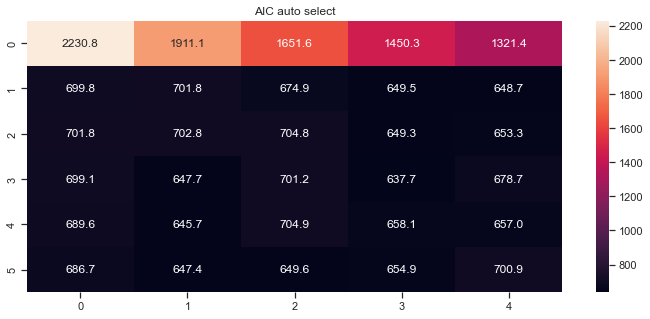

In [26]:
auto_select = sm.tsa.stattools.arma_order_select_ic(dfm.Temperature, max_ar=5, max_ma=4, ic='aic', trend='n', model_kw={}, fit_kw={})

print(auto_select.aic_min_order)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.ylim([auto_select['aic'].shape[0], 0])
plt.title('AIC auto select')
plt.show()

In [29]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [38]:
dfmT = dfm.Temperature

In [39]:
dfmT.head(2)

date
2000-01-31    25.587742
2000-02-29    24.753103
Freq: M, Name: Temperature, dtype: float64

In [42]:
test_split = 0.20
dfmT_train, dfmT_test = split_data(dfmT, test_split)

train: 192 , test: 48


In [44]:

P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(3))]*3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P,D,Q) in enumerate(vals):
    if i%15 ==0:
        #print(f'Running model #(i) using SARIMA({p},{d},{q})({P},{D},{Q},12)')
        m = SARIMAX(dfmT_train, order=(p,d,q),
                    seasonal_order = (P,D,Q,12),enforce_stationarity=False)
        res = m.fit(disp=0)
        y = dfmT_train.values.ravel()
        y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q), 'seasonal order':(P,D,Q),
                    'AIC':res.aic,
                    'RMSPE': rmspe(y, y_hat),
                    'BIC': res.bic,
                    'AICc':res.aicc,
                    'RMSE' : rmse(y, y_hat),
                    'MAPE' : mape(y, y_hat),
                    'model': res}

In [45]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score=v[c]
            best_model = k
            print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [46]:
best_model = get_best_model(score,'AIC')

Best model: 15 with lowest AIC score: 447.9810077988656
Best model: 30 with lowest AIC score: 422.09430220958535
Best model: 45 with lowest AIC score: 367.1867836738364
Best model: 75 with lowest AIC score: 329.35107721919064
Best model: 615 with lowest AIC score: 321.70764657222253


In [47]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,non-seasonal order,seasonal order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,626,"(2, 1, 2)","(0, 1, 2)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,618,"(2, 1, 1)","(2, 2, 0)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,619,"(2, 1, 1)","(2, 2, 1)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,620,"(2, 1, 1)","(2, 2, 2)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,621,"(2, 1, 2)","(0, 0, 0)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


Sarimax exogenous using other variables in the dataset. 


In [48]:
def correlation_heat_map(df):
    corrs = np.round(df.corr(),decimals=2)*100
    fig, ax = plt.subplots(figsize=(20, 15))

   
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns.
    ax = sns.heatmap(corrs, mask=mask, annot=True,cmap='RdBu')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=40)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)
    plt.show()

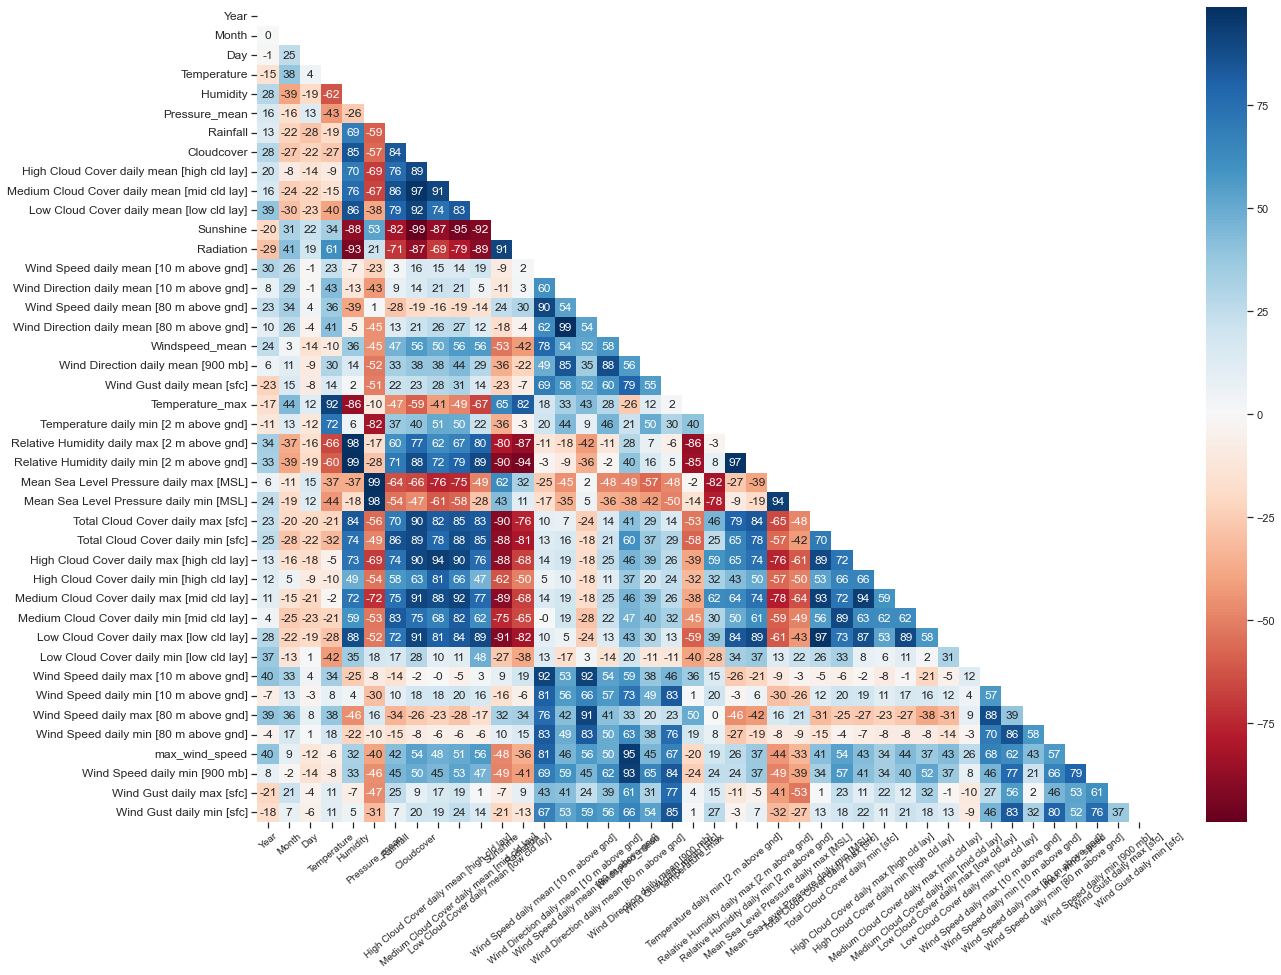

In [49]:
correlation_heat_map(dfm)

In [50]:
dfm.columns

Index(['Year', 'Month', 'Day', 'Temperature', 'Humidity', 'Pressure_mean',
       'Rainfall', 'Cloudcover', 'High Cloud Cover daily mean [high cld lay]',
       'Medium Cloud Cover daily mean [mid cld lay]',
       'Low Cloud Cover daily mean [low cld lay]', 'Sunshine', 'Radiation',
       'Wind Speed daily mean [10 m above gnd]',
       'Wind Direction daily mean [10 m above gnd]',
       'Wind Speed daily mean [80 m above gnd]',
       'Wind Direction daily mean [80 m above gnd]', 'Windspeed_mean',
       'Wind Direction daily mean [900 mb]', 'Wind Gust daily mean [sfc]',
       'Temperature_max', 'Temperature daily min [2 m above gnd]',
       'Relative Humidity daily max [2 m above gnd]',
       'Relative Humidity daily min [2 m above gnd]',
       'Mean Sea Level Pressure daily max [MSL]',
       'Mean Sea Level Pressure daily min [MSL]',
       'Total Cloud Cover daily max [sfc]',
       'Total Cloud Cover daily min [sfc]',
       'High Cloud Cover daily max [high cld lay]',
    

In [52]:
exog_columns = [col for col in dfm.columns if '$' in col] + \
['Radiation','Sunshine','Relative Humidity daily max [2 m above gnd]','Relative Humidity daily min [2 m above gnd]','Low Cloud Cover daily max [low cld lay]',]

In [54]:
predictors = dfm[['Year', 'Month', 'Day', 'Humidity', 'Pressure_mean',
       'Rainfall', 'Cloudcover', 'High Cloud Cover daily mean [high cld lay]',
       'Medium Cloud Cover daily mean [mid cld lay]',
       'Low Cloud Cover daily mean [low cld lay]', 'Sunshine', 'Radiation',
       'Wind Speed daily mean [10 m above gnd]',
       'Wind Direction daily mean [10 m above gnd]',
       'Wind Speed daily mean [80 m above gnd]',
       'Wind Direction daily mean [80 m above gnd]', 'Windspeed_mean',
       'Wind Direction daily mean [900 mb]', 'Wind Gust daily mean [sfc]',
       'Temperature_max', 'Temperature daily min [2 m above gnd]',
       'Relative Humidity daily max [2 m above gnd]',
       'Relative Humidity daily min [2 m above gnd]',
       'Mean Sea Level Pressure daily max [MSL]',
       'Mean Sea Level Pressure daily min [MSL]',
       'Total Cloud Cover daily max [sfc]',
       'Total Cloud Cover daily min [sfc]',
       'High Cloud Cover daily max [high cld lay]',
       'High Cloud Cover daily min [high cld lay]',
       'Medium Cloud Cover daily max [mid cld lay]',
       'Medium Cloud Cover daily min [mid cld lay]',
       'Low Cloud Cover daily max [low cld lay]',
       'Low Cloud Cover daily min [low cld lay]',
       'Wind Speed daily max [10 m above gnd]',
       'Wind Speed daily min [10 m above gnd]',
       'Wind Speed daily max [80 m above gnd]',
       'Wind Speed daily min [80 m above gnd]', 'max_wind_speed',
       'Wind Speed daily min [900 mb]', 'Wind Gust daily max [sfc]',
       'Wind Gust daily min [sfc]']]

In [55]:
X = predictors
y = dfm.Temperature

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
period = 12
model_exog = SARIMAX(endog=dfm.Temperature, exog = X[['Radiation','Sunshine','Relative Humidity daily max [2 m above gnd]','Relative Humidity daily min [2 m above gnd]','Low Cloud Cover daily max [low cld lay]']],
                                       order = (3,1,1),
                                       seasonal_order = (3,1,0, period))

results_exog = model_exog.fit(maxiter=100)
results_exog.summary()
                                       

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81117D-01    |proj g|=  8.07390D+01


 This problem is unconstrained.



At iterate    5    f=  8.74388D-01    |proj g|=  1.87862D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  8.73303D-01    |proj g|=  7.97947D+00

At iterate   15    f=  8.69898D-01    |proj g|=  1.00657D+00

At iterate   20    f=  8.69739D-01    |proj g|=  7.87258D+00

At iterate   25    f=  8.62520D-01    |proj g|=  6.29259D+01

At iterate   30    f=  8.54289D-01    |proj g|=  1.02515D+00

At iterate   35    f=  8.53870D-01    |proj g|=  5.05581D+00

At iterate   40    f=  8.51617D-01    |proj g|=  6.84387D+00

At iterate   45    f=  8.37292D-01    |proj g|=  1.67961D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     45     92      2     0     0   1.680D+00   8.373D-01
  F =  0.837292298355


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Temperature   No. Observations:                  240
Model:             SARIMAX(3, 1, 1)x(3, 1, [], 12)   Log Likelihood                -200.950
Date:                             Wed, 21 Sep 2022   AIC                            427.900
Time:                                     17:28:42   BIC                            472.425
Sample:                                 01-31-2000   HQIC                           445.867
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Radiation                                      -0.0004      0.000     -1.597      0.110      -0.001    9.26e-05
Sunshine                                        0.0037      0.001      2.686      0.007       0.001       0.006
Relative Humidity daily max [2 m above gnd]     0.0140      0.025      0.559      0.576      -0.035       0.063
Relative Humidity daily min [2 m above gnd]    -0.1288      0.030     -4.309      0.000      -0.187      -0.070
Low Cloud Cover daily max [low cld lay]         0.0212      0.005      4.135      0.000       0.011       0.031
ar.L1                                          -0.2162      0.347     -0.622      0.534      -0.897       0.465
ar.L2                                          -0.2863      0.190     -1.503      0.133      -0.660       0.087
ar.L3                                          -0.0592      0.172     -0.344      0.731      -0.397       0.279
ma.L1                                          -0.3672      0.348     -1.055      0.291      -1.049       0.315
ar.S.L12                                       -0.6104      0.072     -8.423      0.000      -0.752      -0.468
ar.S.L24                                       -0.4456      0.077     -5.782      0.000      -0.597      -0.295
ar.S.L36                                       -0.2683      0.061     -4.369      0.000      -0.389      -0.148
sigma2                                          0.3263      0.026     12.504      0.000       0.275       0.377
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                23.49
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.22
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""